In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio



md = pd.read_csv('Medical Dataset.csv')

md.head()

,ID,Department,Birth place,Discharge diagnosis,Other diagnoses for discharge,Admission time,Discharge time,days,fees and,outpatient physician,...,lab fees,Inspection fees,Western medicine fees,Nursing fee,grass fee,Anesthesia fee,Other fees,Surgery Fees,bed fee,Medical fees
0,1,"Department of Obstetrics and Gynecology, Weste...",Guizhou,G1P1 LSA cesarean section at 38 weeks gestation,Breech presentation,2/4/2016,2/23/2016,NaN,2825.32,Korea**,...,579.5,30.0,227.24,108,0.0,406.0,346.48,500,63.6,556.0
1,2,"Department of Obstetrics and Gynecology, Sout...","Anshun, Guizhou",G4P1 Mid-term induction of labor at 24+6 week...,Mild anemia during pregnancy,2/15/2016,2/19/2016,NaN,2163.08,Gu**,...,499.0,120.0,50.00,42,0.0,15.0,645.68,470,54.4,266.5
2,3,Internal Medicine,"Anshun, Guizhou",type 2 diabetes,reactive hypoglycemia,1/25/2016,2/17/2016,NaN,1649.48,Yin**,...,539.5,176.0,339.58,42,0.0,0.0,243.20,0,88.2,171.0
3,4,"Department of Obstetrics and Gynecology, Sout...",Guizhou,G1P0 induced labor at mid-22nd week of pregnancy,infant deformity,2/17/2016,2/23/2016,NaN,1363.52,Zhang Si,...,450.5,120.0,40.93,46,0.0,15.0,72.19,470,54.4,94.5
4,5,"Department of Obstetrics and Gynecology, West...","Anshun, Guizhou",G1P0 50 days pregnant,incomplete abortion,2/5/2016,2/16/2016,11.0,1024.74,Korea**,...,636.0,90.0,80.49,18,0.0,0.0,38.45,70,31.8,60.0


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Task 1: Data Cleaning and Preprocessing
Proper data cleaning is essential to remove inaccuracies, ensure consistency, and
prepare the data for analysis.

##1. _**Datetime Conversion**_:
Convert the 'Time of Admission' and 'Time of Discharge' columns to
datetime format.

In [7]:
for column in md.columns:
    print(f"{column}: {md[column].dtype}")

ID: int64
Department: object
Birth place: object
Discharge diagnosis: object
Other diagnoses for discharge: object
Admission time: object
Discharge time: object
days: float64
fees and: float64
outpatient physician: object
Outpatient physician department: object
lab fees: float64
Inspection fees: float64
Western medicine fees: float64
Nursing fee: int64
grass fee: float64
Anesthesia fee: float64
Other fees: float64
Surgery Fees: int64
bed fee: float64
Medical fees: float64


In [8]:
# 1. Datetime Conversion
md['Admission time'] = pd.to_datetime(md['Admission time'])
md['Discharge time'] = pd.to_datetime(md['Discharge time'])




## 2. ***Column Name Standardization***:
Clean up column names to remove extra spaces and special characters.

In [9]:
# 2. Column Name Standardization
md.columns = md.columns.str.strip().str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '', regex=True).str.lower()



## 3. ***Handle Missing or Inconsistent Data***:
Identify and address missing, null, or inconsistent values (e.g., negative
expenses, admission after discharge).

In [10]:
# 3. Handle Missing or Inconsistent Data

# a. Identify missing values
print(md.isnull().sum())  # Print the number of missing values in each column

# b. Handle missing values (choose one or a combination of methods)
# - Drop rows with missing values in specific columns
#md.dropna(subset=['important_column1', 'important_column2'], inplace=True)

# - Impute missing values with mean/median/mode
md['days'] = md['days'].fillna(md['days'].mean())
# md['categorical_column'].fillna(md['categorical_column'].mode()[0], inplace=True)

# c. Handle inconsistent data
# - Replace negative expenses with 0
md['lab_fees'] = md['lab_fees'].clip(lower=0)
md['inspection_fees'] = md['inspection_fees'].clip(lower=0)
# ... (similarly for other expense columns)

# - Filter out rows with admission after discharge
md = md[md['admission_time'] <= md['discharge_time']]


id                                 0
department                         0
birth_place                        0
discharge_diagnosis                0
other_diagnoses_for_discharge      0
admission_time                     0
discharge_time                     0
days                               4
fees_and                           0
outpatient_physician               0
outpatient_physician_department    0
lab_fees                           0
inspection_fees                    0
western_medicine_fees              0
nursing_fee                        0
grass_fee                          0
anesthesia_fee                     0
other_fees                         0
surgery_fees                       0
bed_fee                            0
medical_fees                       0
dtype: int64


## 4. ***Data Validation*** :

Perform basic validation on key columns to ensure no anomalies such as
unrealistic expense values or time intervals.

In [11]:
# 4. Data Validation

def validate_data(data):
    """Performs basic data validation checks on key columns.

    Args:
        data (pd.DataFrame): The hospital dataset.

    Returns:
        pd.DataFrame: The dataset with validation results.
    """

    # Check for negative values in expense columns
    expense_cols = ['lab_fees', 'inspection_fees', 'western_medicine_fees', 'nursing_fee',
                    'grass_fee', 'anesthesia_fee', 'other_fees', 'surgery_fees', 'bed_fee',
                    'medical_fees']  # Add other expense columns as needed
    for col in expense_cols:
        data[col + '_valid'] = data[col] >= 0

    # Check for unrealistic expense values (e.g., values exceeding a certain threshold)
    # Customize the threshold based on your domain knowledge
    expense_threshold = 100000  # Example threshold
    for col in expense_cols:
        data[col + '_realistic'] = data[col] <= expense_threshold

    # Check for unrealistic time intervals (e.g., negative or very long stays)
    data['stay_duration'] = (data['discharge_time'] - data['admission_time']).dt.days
    data['stay_duration_valid'] = data['stay_duration'] >= 0
    data['stay_duration_realistic'] = data['stay_duration'] <= 365  # Example threshold for stay duration



    return data


# Apply data validation function
md = validate_data(md)

# Print validation results (or subset for specific columns)
validation_cols = [col for col in md.columns if col.endswith('_valid') or col.endswith('_realistic')]
print(md[validation_cols])


     lab_fees_valid  inspection_fees_valid  western_medicine_fees_valid  \
0              True                   True                         True   
1              True                   True                         True   
2              True                   True                         True   
3              True                   True                         True   
4              True                   True                         True   
..              ...                    ...                          ...   
522            True                   True                         True   
523            True                   True                         True   
524            True                   True                         True   
525            True                   True                         True   
526            True                   True                         True   

     nursing_fee_valid  grass_fee_valid  anesthesia_fee_valid  \
0                 True            

# ***Task 2: Exploratory Data Analysis (EDA)***
Gain insights into the dataset by exploring relationships between different features.
You should:

## 1. ***Average Stay Duration***:
Calculate the average stay duration by finding the difference between
'Time of Admission' and 'Time of Discharge'.

In [12]:
# 1. Average Stay Duration
md['stay_duration'] = (md['discharge_time'] - md['admission_time']).dt.days
average_stay_duration = md['stay_duration'].mean()

print(f"Average Stay Duration: {average_stay_duration} days")


Average Stay Duration: 13.698292220113853 days


## 2. ***Departmental Analysis***:

Group the data by 'Department' and calculate the average 'Medical
Expenses' for each department.

In [13]:
average_expenses_by_department = md.groupby('department')['medical_fees'].mean()

print(average_expenses_by_department)

department
 Department of Obstetrics and Gynecology, South Hospital       394.048780
 Department of Obstetrics and Gynecology, Western Hospital     342.272727
 Department of Surgery                                         533.022727
 Emergency Department                                          377.500000
 Internal Medicine                                             388.607240
 Neck, shoulder, waist and leg pain department                3974.533333
 Pediatrics                                                    432.727273
 Second Department of Surgery                                  498.566667
Department of Obstetrics and Gynecology, Western Hospital      556.000000
Name: medical_fees, dtype: float64


## 3. ***Common Discharge Diagnosis***:
Identify the most frequent 'Discharge Diagnosis' across all patients.
### ***Bonus:***
Visualize distributions of key variables (e.g., using box plots or
histograms) to show the spread and outliers in features such as 'Medical
Expenses'.
Investigate potential seasonal trends in admissions or expenses by
grouping the data by month or quarter.

Most Frequent Discharge Diagnosis: community acquired pneumonia


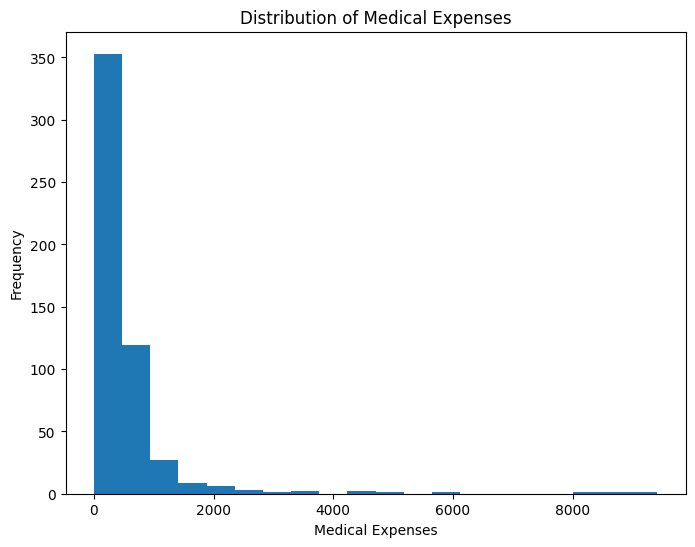

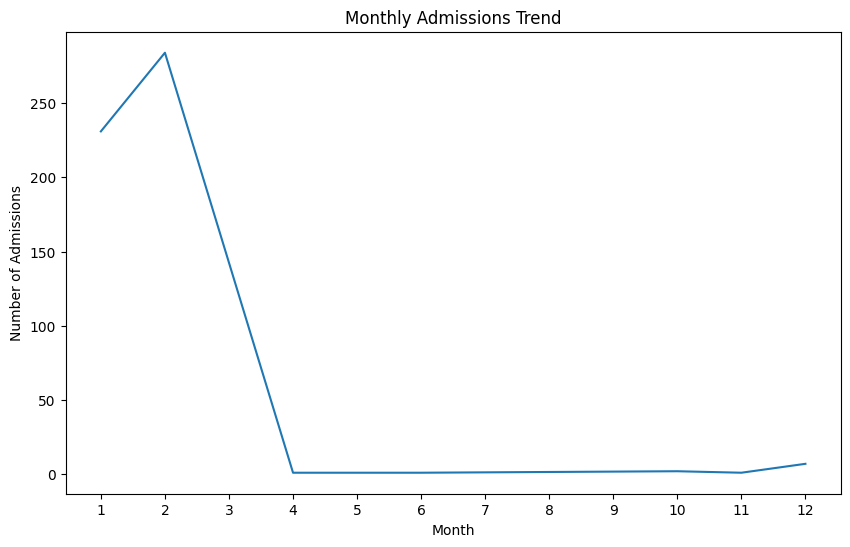

In [14]:

# 1. Most Frequent Discharge Diagnosis
most_frequent_diagnosis = md['discharge_diagnosis'].mode()[0]
print(f"Most Frequent Discharge Diagnosis: {most_frequent_diagnosis}")

# 2. Visualize Distributions (using histogram for 'medical_fees')
plt.figure(figsize=(8, 6))
plt.hist(md['medical_fees'], bins=20)  # Use histogram instead of boxplot
plt.title('Distribution of Medical Expenses')
plt.xlabel('Medical Expenses')
plt.ylabel('Frequency')
plt.show()

# 3. Investigate Seasonal Trends (example with monthly admissions)
md['admission_month'] = md['admission_time'].dt.month
monthly_admissions = md.groupby('admission_month')['admission_time'].count()

plt.figure(figsize=(10, 6))
plt.plot(monthly_admissions.index, monthly_admissions.values)
plt.title('Monthly Admissions Trend')
plt.xlabel('Month')
plt.ylabel('Number of Admissions')
plt.xticks(range(1, 13))  # Set x-axis ticks to represent months
plt.show()

# ***Task 3: Data Aggregation and Grouping***
Summarizing and grouping data can provide deeper insights into various segments
of the dataset. Perform the following:

## 1. ***Place of Birth Summary***:
Summarize total 'Expenses and Outpatient' and 'Medical Expenses' for
each 'Place of Birth'.

In [15]:
for column in md.columns:
  if md[column].dtype != 'bool':
    print(f"{column}: {md[column].dtype}")



id: int64
department: object
birth_place: object
discharge_diagnosis: object
other_diagnoses_for_discharge: object
admission_time: datetime64[ns]
discharge_time: datetime64[ns]
days: float64
fees_and: float64
outpatient_physician: object
outpatient_physician_department: object
lab_fees: float64
inspection_fees: float64
western_medicine_fees: float64
nursing_fee: int64
grass_fee: float64
anesthesia_fee: float64
other_fees: float64
surgery_fees: int64
bed_fee: float64
medical_fees: float64
stay_duration: int64
admission_month: int32


In [16]:
md['expenses_and_outpatient'] = (  md['lab_fees']
                               + md['inspection_fees']
                               + md['western_medicine_fees']
                               + md['nursing_fee']
                               + md['grass_fee']
                               + md['anesthesia_fee']
                               + md['other_fees']
                               + md['surgery_fees']
                               + md['bed_fee']
                               + md['fees_and']
                               ).sum()

#print(md['expenses_and_outpatient'])
birth_place_summary = md.groupby('birth_place')[['expenses_and_outpatient', 'medical_fees']].sum()

print(birth_place_summary)

                                       expenses_and_outpatient  medical_fees
birth_place                                                                 
Anshun                                            1.552344e+08       21050.0
Anshun City                                       1.308839e+08       23019.0
Anshun City Three Taiwan Grain Bureau             3.043812e+06         457.0
Anshun Ninggu Shangyuan                           3.043812e+06         351.0
Anshun, Guizhou                                   8.735740e+08      148506.7
...                                                        ...           ...
Zhejiang                                          3.043812e+06        3719.5
Zhenning, Guizhou                                 3.043812e+06         428.5
development zone                                  3.043812e+06         514.0
local                                             1.826287e+07       23240.5
xishuiguan                                        3.043812e+06         553.0

## 2. ***Departmental Expense Analysis***:

Determine the average 'Surgery Expenses' and 'Bed Fees' for each
'Department'.
### ***Bonus:***
To analyze medical expenses across these categories, perform multi-level
grouping (e.g., by both 'Department' and 'Discharge Diagnosis').

Aggregate expenses and patient numbers over time (e.g., monthly trends)
to uncover hospital resource usage patterns.

In [17]:
# 2. Departmental Expense Analysis

# a. Average Surgery Expenses and Bed Fees by Department
departmental_expenses = md.groupby('department')[['surgery_fees', 'bed_fee']].mean()
print("Departmental Expenses (Average):\n", departmental_expenses)

# Bonus:

# b. Multi-level Grouping (Department and Discharge Diagnosis)
multi_level_expenses = md.groupby(['department', 'discharge_diagnosis'])[['surgery_fees', 'bed_fee']].mean()
print("\nMulti-level Expenses (Average):\n", multi_level_expenses)

# c. Aggregate Expenses and Patient Numbers over Time (Monthly)
md['admission_month'] = md['admission_time'].dt.month
monthly_expenses = md.groupby('admission_month')[['surgery_fees', 'bed_fee']].sum()
monthly_patients = md.groupby('admission_month')['admission_time'].count()

print("\nMonthly Expenses (Total):\n", monthly_expenses)
print("\nMonthly Patient Numbers:\n", monthly_patients)

Departmental Expenses (Average):
                                                     surgery_fees     bed_fee
department                                                                  
 Department of Obstetrics and Gynecology, South...    479.658537   89.265854
 Department of Obstetrics and Gynecology, Weste...    566.939394   72.975758
 Department of Surgery                                482.878788   92.354545
 Emergency Department                                   0.000000   81.411111
 Internal Medicine                                      1.583710   99.186425
 Neck, shoulder, waist and leg pain department        192.000000  229.800000
 Pediatrics                                             0.000000   47.181818
 Second Department of Surgery                         234.666667  120.280000
Department of Obstetrics and Gynecology, Wester...    500.000000   63.600000

Multi-level Expenses (Average):
                                                                                      

# ***Task 4: Data Visualization***
Effective visualizations help in interpreting the data and communicating results.
Create the following plots:

## 1. ***Stay Duration Histogram***:
Plot a histogram of the 'Days' patients stayed in the hospital.

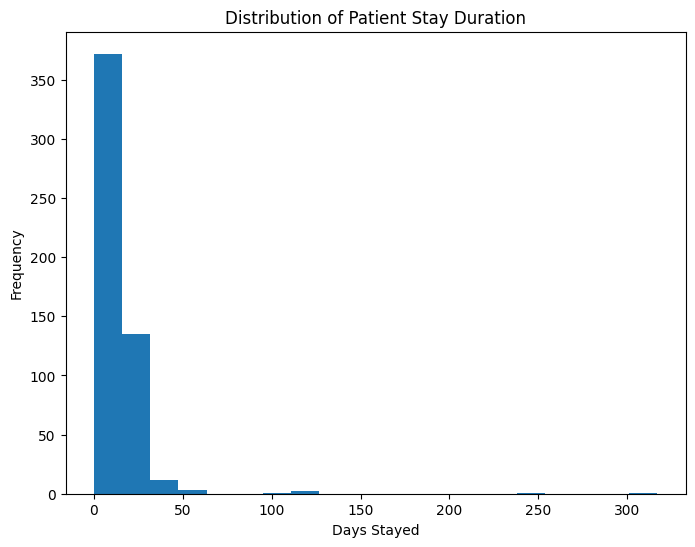

In [18]:
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.hist(md['days'], bins=20)  # Adjust 'bins' for desired granularity
plt.title('Distribution of Patient Stay Duration')
plt.xlabel('Days Stayed')
plt.ylabel('Frequency')
plt.show()

## 2. ***Departmental Expenses Bar Chart***:

Plot a bar chart showing the total 'Medical Expenses' for each department.

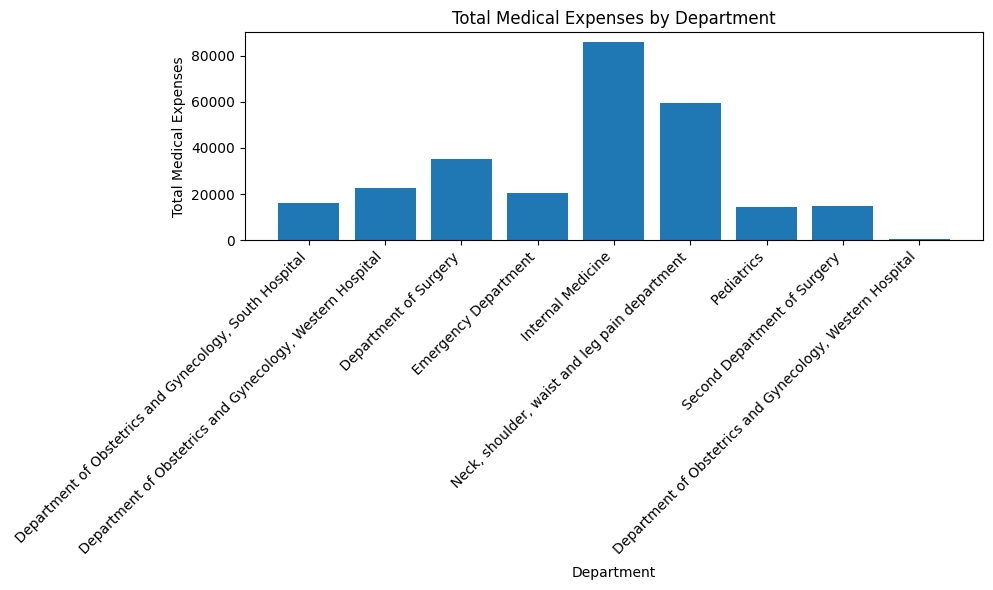

In [19]:
import matplotlib.pyplot as plt

departmental_expenses = md.groupby('department')['medical_fees'].sum()

plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(departmental_expenses.index, departmental_expenses.values)
plt.title('Total Medical Expenses by Department')
plt.xlabel('Department')
plt.ylabel('Total Medical Expenses')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

## 3. **Nursing Expenses Over Time**:
Generate a line plot showing the trend of 'Nursing Expenses' over time,
based on the 'Time of Admission'.
Bonus:
Create more sophisticated plots like heatmaps for visualizing correlations
between numerical variables, or stacked bar charts to show expenses
broken down by both 'Department' and 'Place of Birth'.
Explore using interactive plotting libraries like Plotly to enhance your
visualizations.

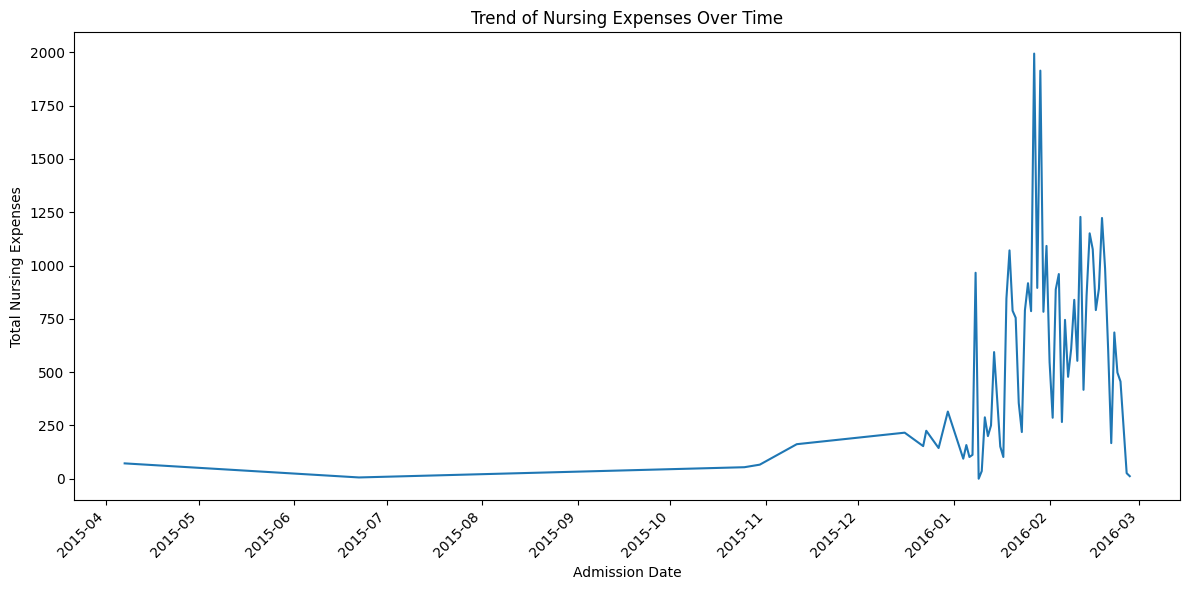

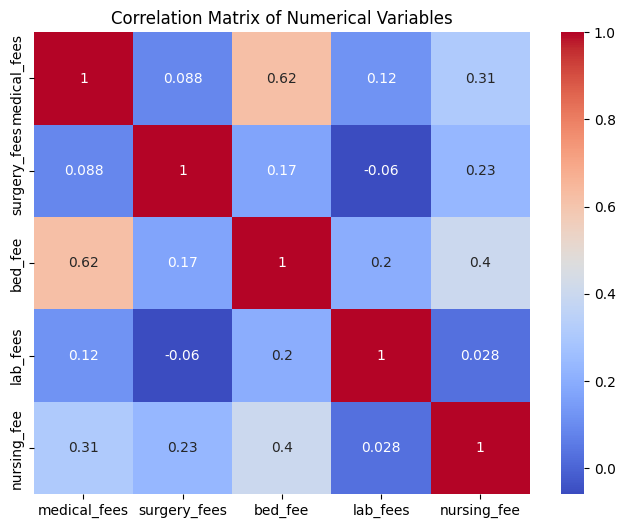

<ipython-input-20-61a03adfb332>:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


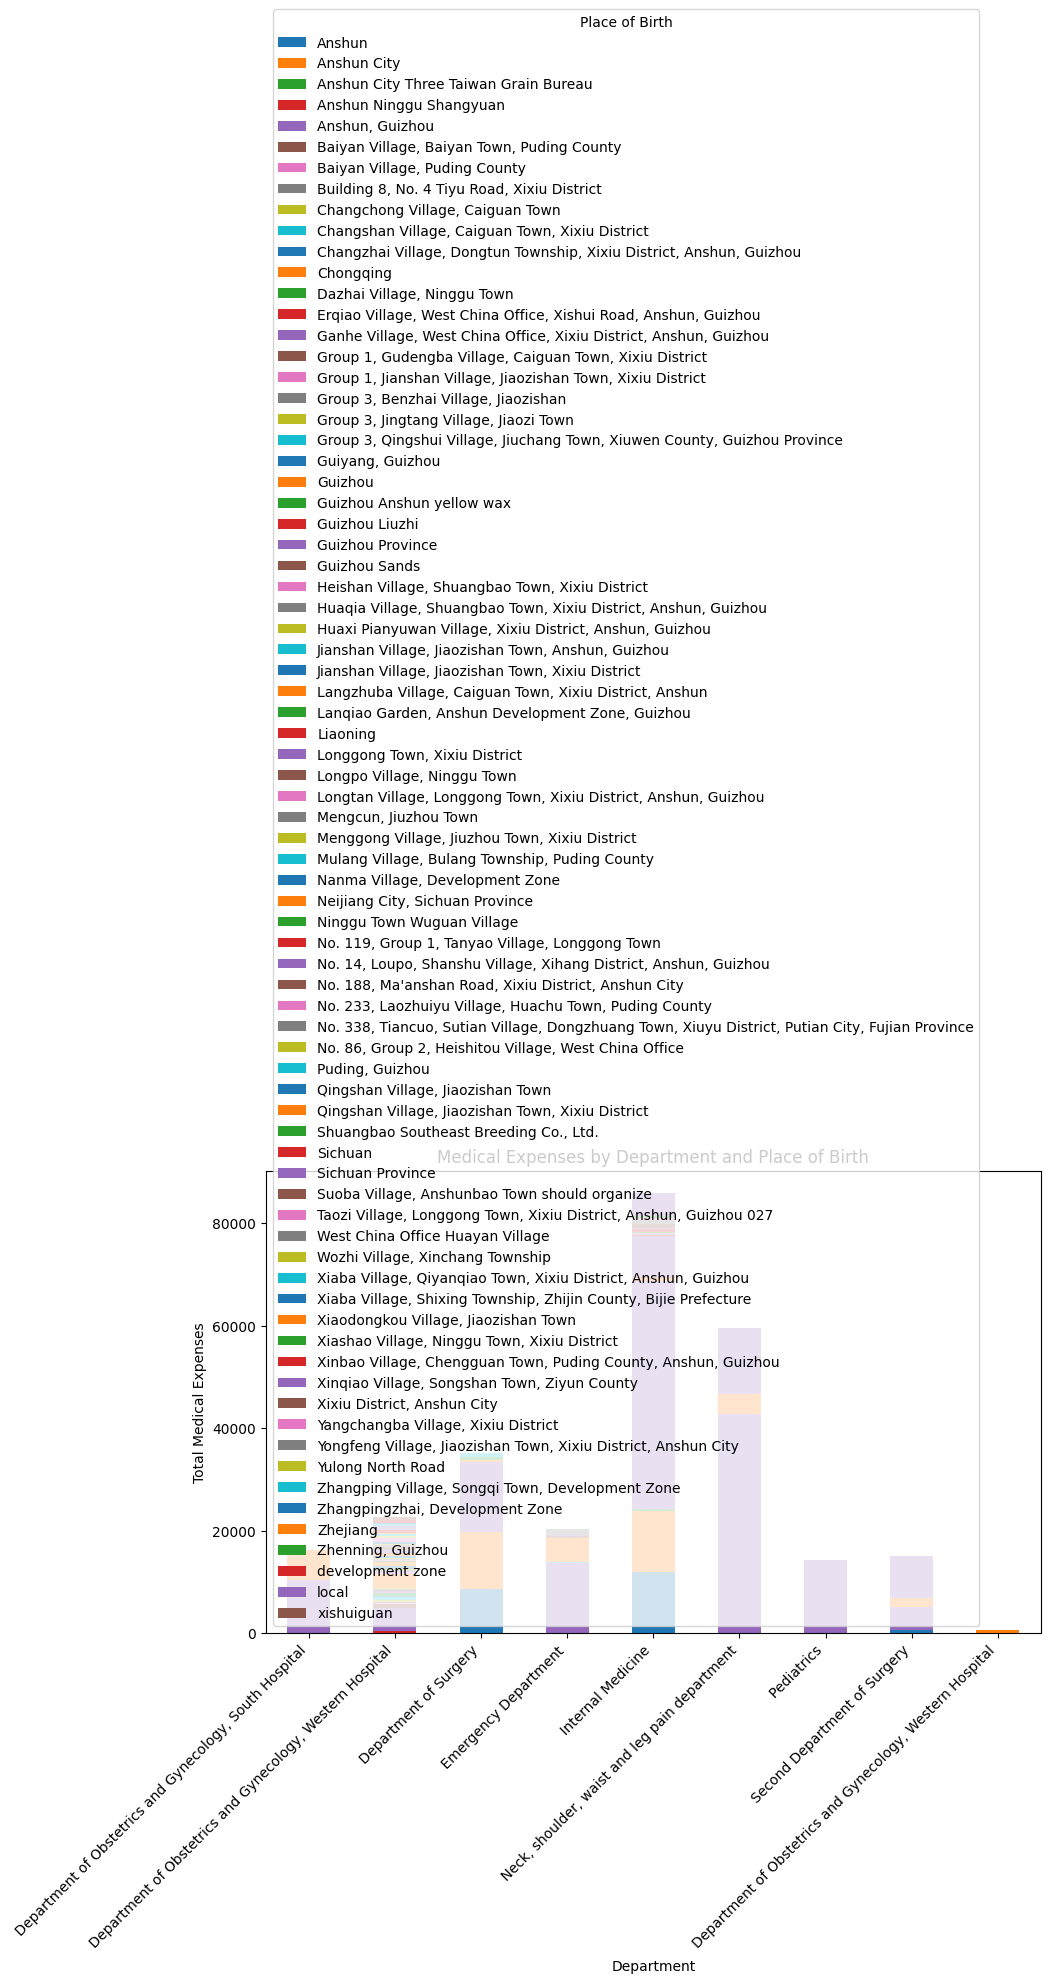

In [20]:
# 3. Nursing Expenses Over Time

# a. Line Plot
md['admission_date'] = md['admission_time'].dt.date  # Extract date from admission_time
nursing_expenses_over_time = md.groupby('admission_date')['nursing_fee'].sum()

plt.figure(figsize=(12, 6))
plt.plot(nursing_expenses_over_time.index, nursing_expenses_over_time.values)
plt.title('Trend of Nursing Expenses Over Time')
plt.xlabel('Admission Date')
plt.ylabel('Total Nursing Expenses')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Bonus:

# b. Heatmap for Correlations
numerical_cols = ['medical_fees', 'surgery_fees', 'bed_fee', 'lab_fees', 'nursing_fee']  # Add other numerical columns
correlation_matrix = md[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()


# c. Stacked Bar Chart (Department and Place of Birth)
department_birth_place_expenses = md.groupby(['department', 'birth_place'])['medical_fees'].sum().unstack()

department_birth_place_expenses.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Medical Expenses by Department and Place of Birth')
plt.xlabel('Department')
plt.ylabel('Total Medical Expenses')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Place of Birth')
plt.tight_layout()
plt.show()


# Task 5: ***Advanced Analysis (Optional)***
For those seeking an additional challenge, try these advanced tasks:

## 1. ***Correlation Analysis***:
Perform a correlation analysis between 'Medical Expenses' and other
numerical expense-related columns to see if any strong relationships
exist.

In [21]:
# 1. Correlation Analysis

# Select relevant numerical columns for correlation analysis
expense_cols = ['medical_fees', 'surgery_fees', 'bed_fee', 'lab_fees', 'nursing_fee',
                'inspection_fees', 'western_medicine_fees', 'grass_fee',
                'anesthesia_fee', 'other_fees']  # Include other relevant expense columns

# Calculate the correlation matrix
correlation_matrix = md[expense_cols].corr()

# Print the correlation matrix
print(correlation_matrix)

# Optionally, you can filter for strong correlations (e.g., above a threshold)
threshold = 0.7  # Adjust threshold as needed
strong_correlations = correlation_matrix[correlation_matrix > threshold]
print("\nStrong Correlations (above threshold):\n", strong_correlations)


                       medical_fees  surgery_fees   bed_fee  lab_fees  \
medical_fees               1.000000      0.087956  0.622056  0.119848   
surgery_fees               0.087956      1.000000  0.170884 -0.059846   
bed_fee                    0.622056      0.170884  1.000000  0.199122   
lab_fees                   0.119848     -0.059846  0.199122  1.000000   
nursing_fee                0.311214      0.230046  0.401072  0.027640   
inspection_fees            0.100056     -0.138557  0.215264  0.236492   
western_medicine_fees      0.408201     -0.207820  0.530226  0.374730   
grass_fee                  0.061664      0.146578  0.074243  0.006145   
anesthesia_fee            -0.009716      0.804848  0.070144 -0.064742   
other_fees                 0.055859      0.358545  0.266616 -0.006926   

                       nursing_fee  inspection_fees  western_medicine_fees  \
medical_fees              0.311214         0.100056               0.408201   
surgery_fees              0.230046      

## 2. ***Pivot Table Analysis:***
Use pivot tables to analyze the relationship between 'Department', 'Place
of Birth', and 'Medical Expenses'.

In [22]:
# Create a pivot table
pivot_table = pd.pivot_table(
    md,
    values='medical_fees',  # The column you want to analyze (Medical Expenses)
    index='department',  # Rows will be grouped by Department
    columns='birth_place',  # Columns will be grouped by Place of Birth
    aggfunc='mean'  # Aggregation function (e.g., mean, sum, count)
)

# Display the pivot table
print(pivot_table)

birth_place                                             Anshun  Anshun City  \
department                                                                    
 Department of Obstetrics and Gynecology, South...         NaN          NaN   
 Department of Obstetrics and Gynecology, Weste...         NaN          NaN   
 Department of Surgery                              711.541667   531.000000   
 Emergency Department                                      NaN          NaN   
 Internal Medicine                                  323.324324   539.454545   
 Neck, shoulder, waist and leg pain department             NaN          NaN   
 Pediatrics                                                NaN          NaN   
 Second Department of Surgery                       274.250000          NaN   
Department of Obstetrics and Gynecology, Wester...         NaN          NaN   

birth_place                                         Anshun City Three Taiwan Grain Bureau  \
department                           

## 3. ***Predictive Modeling***:
Build a simple regression model to predict 'Medical Expenses' based on
other numerical and categorical variables. Experiment with models like
linear regression or decision trees.

In [25]:
md.head()

,id,department,birth_place,discharge_diagnosis,other_diagnoses_for_discharge,admission_time,discharge_time,days,fees_and,outpatient_physician,...,other_fees_realistic,surgery_fees_realistic,bed_fee_realistic,medical_fees_realistic,stay_duration,stay_duration_valid,stay_duration_realistic,admission_month,expenses_and_outpatient,admission_date
0,1,"Department of Obstetrics and Gynecology, Weste...",Guizhou,G1P1 LSA cesarean section at 38 weeks gestation,Breech presentation,2016-02-04,2016-02-23,13.703633,2825.32,Korea**,...,True,True,True,True,19,True,True,2,3043811.84,2016-02-04
1,2,"Department of Obstetrics and Gynecology, Sout...","Anshun, Guizhou",G4P1 Mid-term induction of labor at 24+6 week...,Mild anemia during pregnancy,2016-02-15,2016-02-19,13.703633,2163.08,Gu**,...,True,True,True,True,4,True,True,2,3043811.84,2016-02-15
2,3,Internal Medicine,"Anshun, Guizhou",type 2 diabetes,reactive hypoglycemia,2016-01-25,2016-02-17,13.703633,1649.48,Yin**,...,True,True,True,True,23,True,True,1,3043811.84,2016-01-25
3,4,"Department of Obstetrics and Gynecology, Sout...",Guizhou,G1P0 induced labor at mid-22nd week of pregnancy,infant deformity,2016-02-17,2016-02-23,13.703633,1363.52,Zhang Si,...,True,True,True,True,6,True,True,2,3043811.84,2016-02-17
4,5,"Department of Obstetrics and Gynecology, West...","Anshun, Guizhou",G1P0 50 days pregnant,incomplete abortion,2016-02-05,2016-02-16,11.000000,1024.74,Korea**,...,True,True,True,True,11,True,True,2,3043811.84,2016-02-05


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Prepare the data:

# Select features (X) and target (y)
features = ['days', 'lab_fees', 'surgery_fees', 'bed_fee', 'nursing_fee','birth_place', 'outpatient_physician', 'department']  # Add more relevant features
target = 'medical_fees'

X = md[features]
y = md[target]

# One-hot encode categorical features (if any)
X = pd.get_dummies(X, columns=['department','birth_place', 'outpatient_physician'], drop_first=True)  # Replace with your categorical features

# Scale numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 2. Split data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Convert data to PyTorch tensors:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)  # Reshape for single target
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

# 4. Create a PyTorch dataset and data loader:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Adjust batch_size

# 5. Define the regression model:
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # Adjust output size if needed

    def forward(self, x):
        return self.linear(x)

# 6. Instantiate the model, optimizer, and loss function:
input_size = X_train_tensor.shape[1]
model = RegressionModel(input_size)
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adjust learning rate
loss_fn = nn.MSELoss()  # Mean Squared Error loss

# 7. Train the model:
epochs = 1000  # Adjust number of epochs
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

# 8. Evaluate the model:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)


    # Calculate Mean Squared Error (MSE)
    mse = loss_fn(y_pred_tensor, y_test_tensor).item()
    print(f"Mean Squared Error: {mse}")

    # Calculate R-squared
    y_pred = y_pred_tensor.numpy()  # Convert to NumPy array
    y_true = y_test_tensor.numpy()

    # Calculate total sum of squares (TSS)
    tss = ((y_true - y_true.mean()) ** 2).sum()

    # Calculate residual sum of squares (RSS)
    rss = ((y_true - y_pred) ** 2).sum()

    # Calculate R-squared
    r2 = 1 - (rss / tss)
    print(f"R-squared: {r2}")





Mean Squared Error: 2004491.125
R-squared: -7.4854736328125


In [46]:
#y_test = y_test.to_numpy()
y_test = y_test.flatten()
print(y_test)
#y_pred = y_pred.to_numpy()
print(y_pred.flatten())
print(y_test.shape)
print(y_pred.shape)

[ 307.   669.5  612.   380.5  330.   499.5  235.5  260.   129.    98.5
  747.   277.   723.5   70.   142.   186.   171.   128.   103.5 1051.5
  360.   243.5  501.5 1936.  1181.5  651.5  344.    15.5  517.  1974.5
 1155.5  511.   200.5 1196.   677.5  216.   935.5  309.5  579.   524.5
  720.5  169.5   70.5  841.5  285.   535.5  410.   237.    56.5  270.5
  560.5  115.5  354.5  858.5  165.5 1877.   102.5  443.   130.5  694.5
 1723.   647.5  187.   460.   351.    99.5  311.5  488.5   34.5  538.4
  747.5  443.   267.5  150.5  304.5  493.5  556.   337.5  126.5  155.5
  283.   137.   542.5  454.  2792.5   73.5  452.5  983.5   54.   677.
  315.   439.5   68.5  107.   480.5  385.5  145.5  220.5  250.5   31.5
   69.5  824.    88.  2216.5   48.    86. ]
[ 2.53093719e+00  3.39556763e+02 -2.63251001e+03  1.67320129e+02
 -2.74346606e+03  4.21636993e+02  3.84823975e+02  3.41402222e+02
 -2.73512500e+03  4.92322540e+00  3.07713470e+02  4.78606293e+02
  8.55936203e+01 -8.87468491e+01  1.12428558e+02  2.

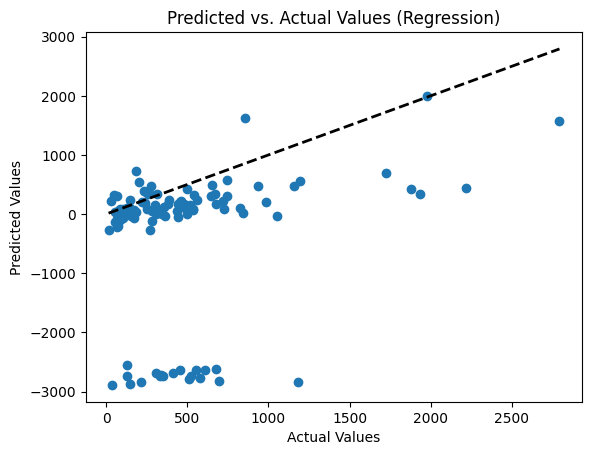

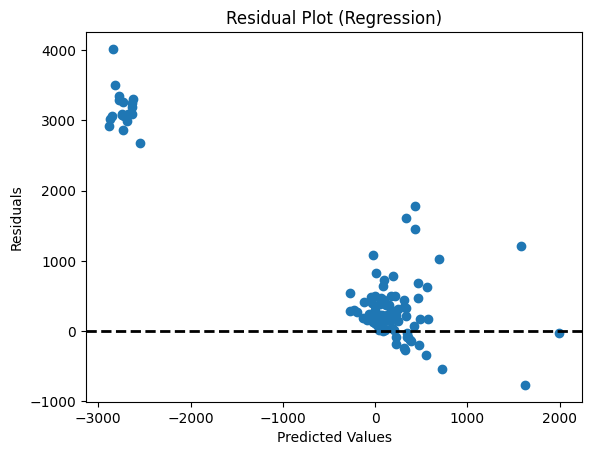

In [47]:
# Visualization

  # Get predicted values for the test set
y_pred = model(X_test_tensor).detach().numpy()

# Plot predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values (Regression)')
plt.show()


# Resisual plot
# Calculate residuals
residuals = y_test.reshape(-1) - y_pred.reshape(-1)
  # Plot residuals
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='k', linestyle='--', lw=2)  # Horizontal line at 0
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Regression)')
plt.show()


## 4. ***Clustering***:

Perform clustering (e.g., k-means) to group patients based on features
like 'Medical Expenses', 'Days Stayed', and 'Discharge Diagnosis' to
uncover potential patterns in patient types.

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Select features for clustering:
features = ['medical_fees', 'days', 'discharge_diagnosis']  # Add other relevant features
X = md[features]

# 2. One-hot encode categorical features:
X = pd.get_dummies(X, columns=['discharge_diagnosis'], drop_first=True)  # Replace with your categorical features

# 3. Scale numerical features:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 4. Convert data to PyTorch tensors:
X_tensor = torch.tensor(X, dtype=torch.float32)

# 5. Define the k-means model:
class KMeans(nn.Module):
    def __init__(self, n_clusters, init='random', max_iter=300):
        super(KMeans, self).__init__()
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter

    def forward(self, x):
        # Initialize centroids
        if self.init == 'random':
            centroids = x[torch.randperm(x.size(0))[:self.n_clusters]]
        else:
            # Implement other initialization methods if needed
            raise NotImplementedError

        for _ in range(self.max_iter):
            # Assign points to clusters
            distances = torch.cdist(x, centroids, p=2)  # Euclidean distance
            cluster_assignments = torch.argmin(distances, dim=1)

            # Update centroids
            for i in range(self.n_clusters):
                cluster_points = x[cluster_assignments == i]
                if len(cluster_points) > 0:
                    centroids[i] = cluster_points.mean(dim=0)

        return cluster_assignments, centroids

# 6. Instantiate the model and perform clustering:
k = 3  # Choose the desired number of clusters
kmeans_model = KMeans(n_clusters=k)
cluster_assignments, centroids = kmeans_model(X_tensor)

# 7. Assign cluster labels to the DataFrame:
md['cluster'] = cluster_assignments.numpy()

# 8. Analyze the clusters:

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)


    # Calculate Mean Squared Error (MSE)
    mse = loss_fn(y_pred_tensor, y_test_tensor).item()
    print(f"Mean Squared Error: {mse}")

    # Calculate R-squared
    y_pred = y_pred_tensor.numpy()  # Convert to NumPy array
    y_true = y_test_tensor.numpy()

    # Calculate total sum of squares (TSS)
    tss = ((y_true - y_true.mean()) ** 2).sum()

    # Calculate residual sum of squares (RSS)
    rss = ((y_true - y_pred) ** 2).sum()

    # Calculate R-squared
    r2 = 1 - (rss / tss)
    print(f"R-squared: {r2}")



   # Assuming you have 2 features: 'medical_fees' and 'days'
   plt.scatter(md['medical_fees'], md['days'], c=md['cluster'])
   plt.xlabel('Medical Fees')
   plt.ylabel('Days Stayed')
   plt.title('Clustering Visualization (Scatter Plot)')
   plt.show()

Mean Squared Error: 2008948.25
R-squared: -7.504341125488281


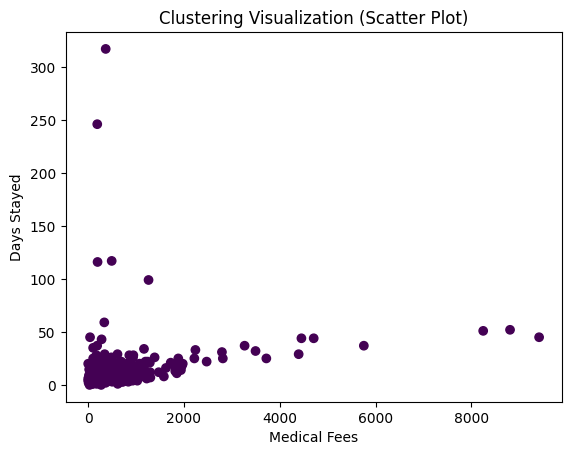

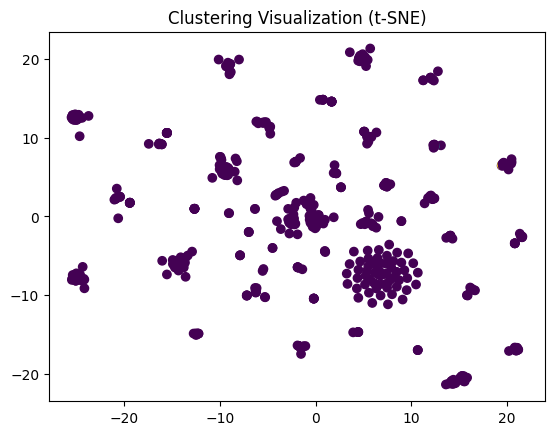

In [51]:
#Visualization
from sklearn.manifold import TSNE

  # Assuming you have 2 features: 'medical_fees' and 'days'
plt.scatter(md['medical_fees'], md['days'], c=md['cluster'])
plt.xlabel('Medical Fees')
plt.ylabel('Days Stayed')
plt.title('Clustering Visualization (Scatter Plot)')
plt.show()


   # Apply t-SNE (or PCA)
tsne = TSNE(n_components=2, random_state=42)  # Adjust n_components and random_state
X_embedded = tsne.fit_transform(X)
   # Plot the embedded data
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=md['cluster'])
plt.title('Clustering Visualization (t-SNE)')
plt.show()